In [1]:
import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jacobian, jit


from jax.experimental import optimizers as jax_opt
import numpy as np





In [2]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt


# Utils
from utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event


Using CPU!


In [3]:
# Build 3 particle events
R = 1.0
N = 180
pad = 3
angles = np.linspace(0, np.pi, N)
energies = np.linspace(0, 1, N)
ij_indices = []

events = []
for i in range(N):
    temp = []
    for j in range(N):

        points = np.array([
                            (energies[j], 0.0, 0.0),
                            ((1-energies[j])/2, R, 0.0),
                            ((1-energies[j])/2, R*np.cos(angles[i]), R*np.sin(angles[i]))
                ])
        temp.append(points)
        ij_indices.append((i,j))
    events.append(temp)


ij_indices = np.array(ij_indices)
dataset = np.array(events)[ij_indices[:,0], ij_indices[:,1]]
print(dataset.shape)

(32400, 3, 3)


In [4]:
# TODO: 
def compute_spectral_representation(events, pad = 125, omega_max = 2, type = "event", dtype = np.float32):

    # events shape is (batch_size, pad, 3)
    points, zs = events[:,:,1:], events[:,:,0]
    batch_size = zs.shape[0]
    euclidean_distance_squared = np.sum(np.square(points[:,:, None, :] - points[:,None, :, :]), axis=-1)
    

    # Upper Triangle Matrices
    if type == "event":
        omega_ij = np.triu(euclidean_distance_squared / 2)
    elif type == "jet":
        omega_ij = np.triu(np.sqrt(euclidean_distance_squared ))
    triangle_indices = np.triu_indices(pad, k = 1)

    ee_ij = np.triu(zs[:,:,None] * zs[:,None,:])
    ee2 = np.trace(ee_ij, axis1 = 1, axis2=2)

    # Flatten to 1D Spectral Representation and remove 0s
    omega_n = omega_ij[:,triangle_indices[0], triangle_indices[1]]
    ee_n = 2 * ee_ij[:,triangle_indices[0], triangle_indices[1]]
    mask = omega_n > 0


    s = np.stack((omega_n, ee_n), axis = 1)
    s = np.transpose(s, (0,2,1))
    print(s.shape)

    
    # Sort and append 0
    indices = s[:,:,0].argsort()
    temp_indices = np.arange(batch_size)[:,np.newaxis]
    s = s[temp_indices,indices]
    s0 = np.zeros((batch_size, 1, 2))
    s0[:,0,1] = ee2
    s = np.concatenate((s0, s), axis = 1)

    return s.astype(dtype)


s = compute_spectral_representation(dataset, pad = pad, type = "jet")

(32400, 3, 2)


In [5]:
def weighted_sum(s, p = 2, max_index = None, inclusive = True):
    
    if max_index is None:
        return jnp.sum(s[:,:,1] * jnp.power(s[:,:,0], p), axis = -1)
    else:
        max_index = max_index + 1 if inclusive else max_index
        return jnp.sum(s[:,:max_index,1] * jnp.power(s[:,:max_index,0], p),axis = -1)


# def energy_sum(s, max_index = None, inclusive = True):
#     if max_index is None:def weighted_sum(s, p = 2, max_index = None, inclusive = True):
    
    if max_index is None:
        return jnp.sum(s[:,:,1] * jnp.power(s[:,:,0], p), axis = -1)
    else:
        max_index = max_index + 1 if inclusive else max_index
        return jnp.sum(s[:,:max_index,1] * jnp.power(s[:,:max_index,0], p),axis = -1)


# def energy_sum(s, max_index = None, inclusive = True):
#     if max_index is None:
#         return jnp.sum(s[:,1])
#     else:
#         max_index = max_index + 1 if inclusive else max_index
#         return jnp.sum(s[:max_index,1] )


def cross_term(s1, s2, pairwise = True):

    # Ijnput Parsing
    if pairwise == False:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == True:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")

    # Cross term
    omega1s = s1[:,:,0]
    omega2s = s2[:,:,0]

    E1s = s1[:,:,1]
    E2s = s2[:,:,1]


    E1_cumsums = jnp.cumsum(E1s, axis = -1)
    E2_cumsums = jnp.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = jnp.concatenate((E1_cumsums[:,0][:,None], E1_cumsums[:,:-1]), axis = -1) 
    shifted_E2_cumsums = jnp.concatenate((E2_cumsums[:,0][:,None], E2_cumsums[:,:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,:,None] * omega2s[:,None,:]
    minE = jnp.minimum(E1_cumsums[:,:,None], E2_cumsums[:,None,:])
    maxE = jnp.maximum(shifted_E1_cumsums[:,:,None], shifted_E2_cumsums[:,None,:])
    x = minE - maxE

    cross = omega_n_omega_l * x * theta(x)
    cross_term = jnp.sum(cross, axis = (-1,-2))


    plt.contourf((omega_n_omega_l * x * theta(x))[0])
    return cross_term

def theta(x):

    return x > 0 


def ds2(s1, s2, pairwise = False):

    if pairwise == True:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == False:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")


    term1 = weighted_sum(s1)
    term2 = weighted_sum(s2)

    return term1 + term2 - 2*cross_term(s1, s2)




def theta_terms(s1, s2, pairwise = True):

    # Ijnput Parsing
    if pairwise == False:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == True:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")

    # Cross term
    omega1s = s1[:,:,0]
    omega2s = s2[:,:,0]

    E1s = s1[:,:,1]
    E2s = s2[:,:,1]


    E1_cumsums = jnp.cumsum(E1s, axis = -1)
    E2_cumsums = jnp.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = jnp.concatenate((E1_cumsums[:,0][:,None], E1_cumsums[:,:-1]), axis = -1) 
    shifted_E2_cumsums = jnp.concatenate((E2_cumsums[:,0][:,None], E2_cumsums[:,:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,:,None] * omega2s[:,None,:]
    minE = jnp.minimum(E1_cumsums[:,:,None], E2_cumsums[:,None,:])
    maxE = jnp.maximum(shifted_E1_cumsums[:,:,None], shifted_E2_cumsums[:,None,:])
    x = minE - maxE

    print(omega_n_omega_l.size * omega_n_omega_l.itemsize * 1e-9)
    print(x.size * x.itemsize * 1e-9)
    print(theta(x).dtype, x.dtype, omega_n_omega_l.dtype)
    print(theta(x).size * theta(x).itemsize * 1e-9)

    cross = omega_n_omega_l * x * theta(x)
    cross_term = jnp.sum(cross, axis = (-1,-2))

    zeros, indices = jnp.count_nonzero(cross, axis = (-1, -2)), jnp.nonzero(cross)
    return zeros, indices


#         return jnp.sum(s[:,1])
#     else:
#         max_index = max_index + 1 if inclusive else max_index
#         return jnp.sum(s[:max_index,1] )


def cross_term(s1, s2, pairwise = True):

    # Ijnput Parsing
    if pairwise == False:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == True:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")

    # Cross term
    omega1s = s1[:,:,0]
    omega2s = s2[:,:,0]

    E1s = s1[:,:,1]
    E2s = s2[:,:,1]


    E1_cumsums = jnp.cumsum(E1s, axis = -1)
    E2_cumsums = jnp.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = jnp.concatenate((E1_cumsums[:,0][:,None], E1_cumsums[:,:-1]), axis = -1) 
    shifted_E2_cumsums = jnp.concatenate((E2_cumsums[:,0][:,None], E2_cumsums[:,:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,:,None] * omega2s[:,None,:]
    minE = jnp.minimum(E1_cumsums[:,:,None], E2_cumsums[:,None,:])
    maxE = jnp.maximum(shifted_E1_cumsums[:,:,None], shifted_E2_cumsums[:,None,:])
    x = minE - maxE

    cross = omega_n_omega_l * x * theta(x)
    cross_term = jnp.sum(cross, axis = (-1,-2))


    return cross_term

def theta(x):

    return x > 0 


def ds2(s1, s2, pairwise = False):

    if pairwise == True:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == False:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")


    term1 = weighted_sum(s1)
    term2 = weighted_sum(s2)

    return term1 + term2 - 2*cross_term(s1, s2)




def theta_terms(s1, s2, pairwise = True):

    # Ijnput Parsing
    if pairwise == False:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == True:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")

    # Cross term
    omega1s = s1[:,:,0]
    omega2s = s2[:,:,0]

    E1s = s1[:,:,1]
    E2s = s2[:,:,1]


    E1_cumsums = jnp.cumsum(E1s, axis = -1)
    E2_cumsums = jnp.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = jnp.concatenate((E1_cumsums[:,0][:,None], E1_cumsums[:,:-1]), axis = -1) 
    shifted_E2_cumsums = jnp.concatenate((E2_cumsums[:,0][:,None], E2_cumsums[:,:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,:,None] * omega2s[:,None,:]
    minE = jnp.minimum(E1_cumsums[:,:,None], E2_cumsums[:,None,:])
    maxE = jnp.maximum(shifted_E1_cumsums[:,:,None], shifted_E2_cumsums[:,None,:])
    x = minE - maxE



    cross = omega_n_omega_l * x * theta(x)
    cross_term = jnp.sum(cross, axis = (-1,-2))

    zeros, indices = jnp.count_nonzero(cross, axis = (-1, -2)), jnp.nonzero(cross)
    return zeros, indices


def sum(f, axis = 0):

    def temp(*args):
        return jnp.sum(f(*args), axis = 0)

    return temp

gradients = grad(sum(ds2), argnums=0)


In [6]:
i, j = np.tril_indices(N, k = -1)
s1 = s[i][:73]
s2 = s[j][:73]
# zeros, indices = theta_terms(s1, s2)

sEMDs = ds2(s1, s2)
dsEMDs_ds1 = gradients(s1, s2)
print(dsEMDs_ds1.shape)
print(dsEMDs_ds1[0], sEMDs[0])

(73, 4, 2)
[[0.         0.        ]
 [0.         0.        ]
 [0.01111076 1.        ]
 [0.01111076 1.        ]] 0.011110764


(array([18., 11.,  9.,  7.,  7.,  6.,  5.,  4.,  3.,  3.]),
 array([0.00986235, 0.02138509, 0.03290782, 0.04443057, 0.0559533 ,
        0.06747604, 0.07899878, 0.09052152, 0.10204425, 0.11356699,
        0.12508973]),
 <BarContainer object of 10 artists>)

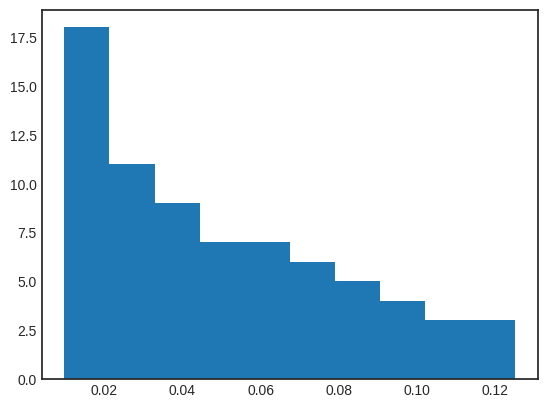

In [7]:
plt.hist(sEMDs)

/tmp/ipykernel_115490/774608795.py:72: RuntimeWarning: invalid value encountered in log10
  plt.contourf(angles, energies, np.log10(sEMDs.T), cmap = "Blues", levels = 25)


Text(0, 0.5, 'Observable')

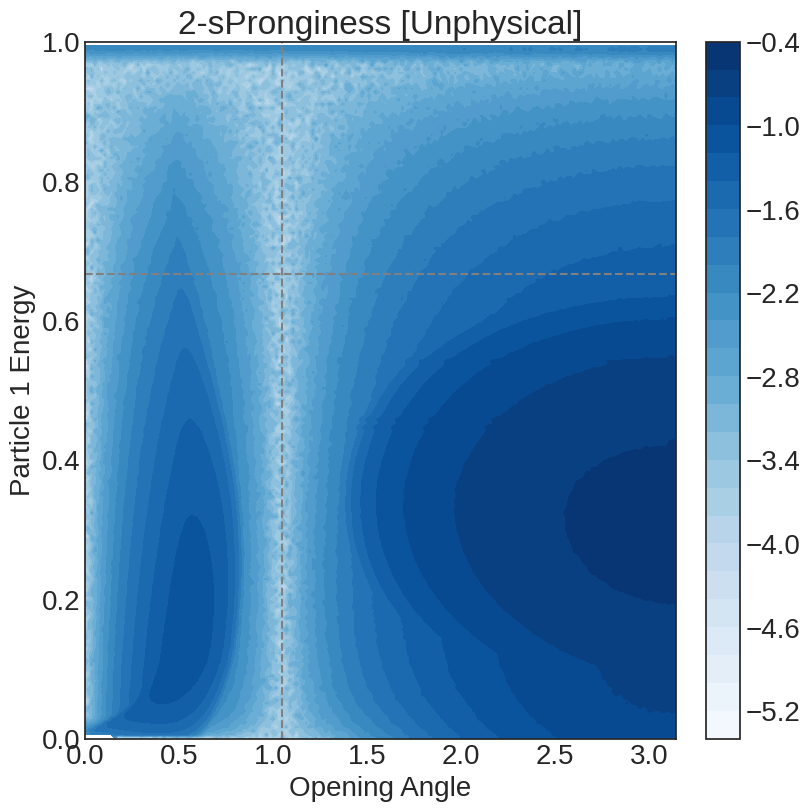

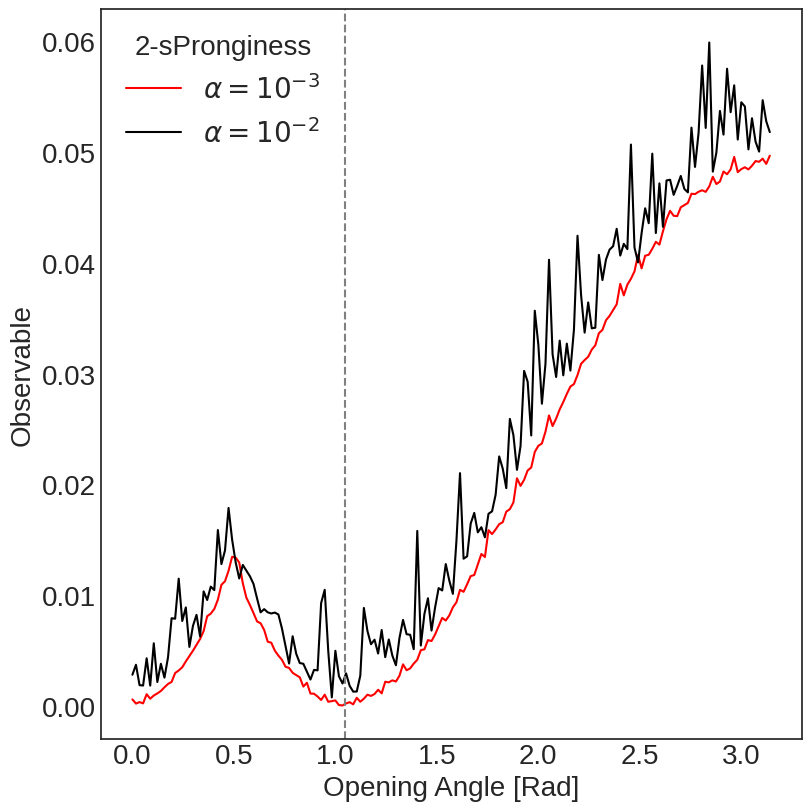

In [8]:
# sEMDs
from tqdm import tqdm


@jax.jit
def train_step(epoch, s, sprongs):

        
    sEMDS = ds2(sprongs, s)
    grads = gradients(sprongs, s)

    return sEMDS, grads

    opt_state = opt_update(epoch, grads, opt_state)
    return opt_state, sEMDS, sprongs


# @jax.jit
def compute_2spronginess(s, alpha = 1e-3):

    batch_size = s.shape[0]
    epochs = 1000



    initial_omega = 0.5
    initial_2ee = 0.2

    # Initialize 2-prong events
    sprongs = np.zeros((batch_size, 2, 2))
    sprongs[:,0,:] = (0, 1-initial_2ee)
    sprongs[:,1,:] = (initial_omega, initial_2ee)

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(alpha)
    opt_state = opt_init(sprongs)

    # ts = []
    # ss = []

    for epoch in range(epochs):

        sprongs = get_params(opt_state)
        sEMDs, grads = train_step(epoch, s, sprongs)
        opt_state = opt_update(epoch, grads, opt_state)


    # plt.scatter(ts,ss)
    return sEMDs, sprongs









sEMDs_2, sprongs = compute_2spronginess(s, 1e-2)
sEMDs_3, sprongs = compute_2spronginess(s, 1e-3)


sEMDs = np.zeros((N,N))
sEMDs[ij_indices[:,0], ij_indices[:,1]] = sEMDs_3


plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8)) 


plt.contourf(angles, energies, np.log10(sEMDs.T), cmap = "Blues", levels = 25)
plt.xlabel("Opening Angle")
plt.ylabel("Particle 1 Energy")
plt.axvline(np.pi/3, ls = "--", color = "grey")
plt.axhline(2/3, ls = "--", color = "grey")

plt.title("2-sPronginess [Unphysical]")
plt.colorbar()
# plt.clabel("log$_{10}d^2$")






plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

# print(angles.shape, np.array(EMDs).shape)

# plt.plot(angles, 2 * np.square(np.array(EMDs)), color = "black", label = r"$\beta$(2-Pronginess)$^\beta$")
plt.plot(angles, np.array(sEMDs_3.reshape((N,N))[:,120]), color = "red", label = r"$\alpha = 10^{-3}$")
plt.plot(angles, np.array(sEMDs_2.reshape((N,N))[:,120]), color = "black", label = r"$\alpha = 10^{-2}$")

plt.axvline(np.pi / 3, color = "grey", ls = "--")
plt.legend(frameon = False, title = "2-sPronginess")

plt.xlabel("Opening Angle [Rad]")
plt.ylabel("Observable")





# def compute_d2prong(angle):

#     sEMDs = []


#     s2prongs = []
#     es = np.linspace(0,0.5, 50)
#     omegas = np.linspace(0,1.5,150)
#     ij = []
#     for (i, e) in enumerate(es):
#         for (j, omega) in enumerate(omegas):
#             s2 = np.array((   (0, 1 - e), (omega, e),     ))
#             s2prongs.append(s2)
#             ij.append((i,j))
#     s2prongs = np.array(s2prongs)
#     ij = np.array(ij)
        


#     indices = [int(angle * 180/np.pi)] * 50*150
#     equilateral_triangles = s[indices]


#     sEMDs = ds2(s2prongs, equilateral_triangles)
#     temp = np.zeros((50,150))
#     temp[ij[:,0], ij[:,1]] = sEMDs

#     argmin = np.unravel_index(np.argmin(temp, axis=None), temp.shape)
#     print(argmin)
#     print(temp[argmin], temp[44,100])
#     plt.imshow(temp)

#     return np.amin(sEMDs)


# compute_d2prong(0)

# # angle_sEMDs = []
# # for angle in tqdm(angles[:-1]):
# #     angle_sEMDs.append(compute_d2prong(angle))








# for angle in tqdm(range(N)):


#     bee = []

#     for energy in range(N):

#         es = np.linspace(0,0.5, 100)
#         omegas = np.array((1,))
#         Es, Omegas = np.meshgrid(es, omegas)
#         temp = np.zeros_like(Es)
    

#         for (i, e) in enumerate(es):
#             for (j, omega) in enumerate(omegas):

#                 s = compute_spectral_representation(events[angle][energy], type = "jet")
#                 s2 = np.array((   (0, 1 - e), (omega, e),     ))
#                 d = ds2(s, s2)
#                 temp[j,i] = d

#         bee.append(np.amin(temp))
#     sEMDs.append(bee)

# sEMDs = np.array(sEMDs)

In [9]:
@jax.jit
def compute_spectral_representation_jax(events, omega_max = 2, is_jet = True, dtype = jnp.float32):

    # events shape is (batch_size, pad, 3)
    points, zs = events[:,:,1:], events[:,:,0]
    batch_size = zs.shape[0]
    euclidean_distance_squared = jnp.sum(jnp.square(points[:,:, None, :] - points[:,None, :, :]), axis=-1)
    

    # # Upper Triangle Matrices
    # if not is_jet:
    #     omega_ij = jnp.triu(euclidean_distance_squared / 2)
    # elif is_jet:


    omega_ij = jnp.triu(euclidean_distance_squared, k = 1)
    triangle_indices = jnp.triu_indices(zs.shape[1], k = 1)



    triangle_indices_i = triangle_indices[0]
    triangle_indices_j = triangle_indices[1]


    ee_ij = jnp.triu(zs[:,:,None] * zs[:,None,:])
    ee2 = jnp.trace(ee_ij, axis1 = 1, axis2=2)

    # Flatten to 1D Spectral Representation and remove 0s
    omega_n = omega_ij[:,triangle_indices_i, triangle_indices_j]
    if is_jet:
        omega_n = jnp.sqrt(omega_n)
    ee_n = 2 * ee_ij[:,triangle_indices_i, triangle_indices_j]


    s = jnp.stack((omega_n, ee_n), axis = 1)
    s = jnp.transpose(s, (0,2,1))
    
    # Sort and append 0
    indices = s[:,:,0].argsort()
    temp_indices = jnp.arange(batch_size)[:,jnp.newaxis]
    s = s[temp_indices,indices]
    s0 = jnp.zeros((batch_size, 1, 1))
    s1 = jnp.concatenate((s0, jnp.expand_dims(ee2, axis = (1,2))), axis = 2)
    s = jnp.concatenate((s1, s), axis = 1)

    return s.astype(dtype)


s_jax = compute_spectral_representation_jax(dataset) 
print(s_jax.shape)



@jax.jit
def physical_ds2(events, s):

    sprongs = compute_spectral_representation_jax(events)
    sEMDs = ds2(sprongs, s)

    return sEMDs

physical_gradients = grad(sum(physical_ds2), argnums=0)

print(physical_gradients(dataset, s[::-1]))
    

(32400, 4, 2)
[[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00            nan            nan]
  [ 0.0000000e+00            nan            nan]]

 [[ 2.0111732e+00  3.1031668e-05  0.0000000e+00]
  [ 3.9888270e+00            nan            nan]
  [ 3.9888268e+00            nan            nan]]

 [[-5.9776535e+00  1.2482330e-04  0.0000000e+00]
  [-4.0223465e+00            nan            nan]
  [-4.0223465e+00            nan            nan]]

 ...

 [[ 2.2346368e-02 -1.2493134e-04 -6.6151395e-24]
  [ 2.0000000e+00  2.4973409e-04 -7.6386575e-21]
  [ 2.0000000e+00 -1.2480275e-04  7.6452725e-21]]

 [[ 4.0111732e+00 -3.0994415e-05  2.2810824e-24]
  [ 6.0000005e+00  6.2401392e-05 -1.9242632e-21]
  [ 6.0000005e+00 -3.1406977e-05  1.9219822e-21]]

 [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 2.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 2.0000000e+00  0.0000000e+00  0.0000000e+00]]]


In [89]:
# sEMDs
from tqdm import tqdm


@jax.jit
def train_step(epoch, s, events):

        
    sEMDS = physical_ds2(events, s)
    grads = physical_gradients(events, s)

    return sEMDS, jnp.nan_to_num(grads)

    opt_state = opt_update(epoch, grads, opt_state)
    return opt_state, sEMDS, sprongs



def project(events):

    temp = jnp.copy(events)
    zs = events[:,:,0]
    num_particles = events.shape[1]
    batch_size = events.shape[0]

    cnt_n = jnp.arange(num_particles)
    cnt_i = jnp.arange(batch_size)

    u = jnp.sort(zs, axis = -1)[:,::-1]
    v = (jnp.cumsum(u, axis = -1)-1) / (cnt_n + 1)
    w = v[cnt_i, jnp.sum(u > v, axis = -1) - 1]
    temp2 = temp.at[:,:,0].set(jnp.maximum(zs - w[:,None], 0))

    return temp2



# @jax.jit
def compute_physical_2spronginess(s, alpha = 1e-3, epochs = 1000):

    batch_size = s.shape[0]


    initial_R = 0.5
    initial_e = 0.8

    # Initialize 2-prong events
    events = np.zeros((batch_size, 2, 3))
    events[:,0,:] = (initial_e, 0, 0)
    events[:,1,:] = (1 - initial_e, 0, initial_R)

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(alpha)
    opt_state = opt_init(events)

    losses = np.zeros((epochs, batch_size))

    for epoch in range(epochs):

        events = get_params(opt_state)
        events = project(events)
        sEMDs, grads = train_step(epoch, s, events)
        opt_state = opt_update(epoch, grads, opt_state)

        losses[epoch] = sEMDs
        


    return sEMDs, events, losses



def compute_physical_3spronginess(s, alpha = 1e-3, epochs = 1000):

    batch_size = s.shape[0]


    initial_R = 0.5
    initial_e = 0.8

    # Initialize 2-prong events
    events = np.zeros((batch_size, 3, 3))
    events[:,0,:] = (initial_e, 0, 0)
    events[:,1,:] = ((1 - initial_e)/2, initial_R, 0)
    events[:,2,:] = ((1 - initial_e)/2, 0, initial_R)

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(alpha)
    opt_state = opt_init(events)

    losses = np.zeros((epochs, batch_size))

    for epoch in range(epochs):

        events = get_params(opt_state)
        events = project(events)
        sEMDs, grads = train_step(epoch, s, events)
        opt_state = opt_update(epoch, grads, opt_state)

        losses[epoch] = sEMDs
        


    return sEMDs, events, losses




# sEMDs_2, events, l = compute_physical_2spronginess(s, 1e-2)
# sEMDs_3, events, l = compute_physical_2spronginess(s, 1e-3)

# print(sEMDs_3)


# sEMDs = np.zeros((N,N))
# sEMDs[ij_indices[:,0], ij_indices[:,1]] = sEMDs_3


# plt.rcParams.update({'font.size': 20})
# fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8)) 


# plt.contourf(angles, energies, np.log10(sEMDs.T), cmap = "Blues", levels = 25)
# plt.xlabel("Opening Angle")
# plt.ylabel("Particle 1 Energy")
# plt.axvline(np.pi/3, ls = "--", color = "grey")
# plt.axhline(2/3, ls = "--", color = "grey")

# plt.title("2-sPronginess [Unphysical]")
# plt.colorbar()
# # plt.clabel("log$_{10}d^2$")






# plt.rcParams.update({'font.size': 20})
# fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

# # print(angles.shape, np.array(EMDs).shape)

# # plt.plot(angles, 2 * np.square(np.array(EMDs)), color = "black", label = r"$\beta$(2-Pronginess)$^\beta$")
# plt.plot(angles, np.array(sEMDs_3.reshape((N,N))[:,120]), color = "red", label = r"$\alpha = 10^{-3}$")
# plt.plot(angles, np.array(sEMDs_2.reshape((N,N))[:,120]), color = "black", label = r"$\alpha = 10^{-2}$")

# plt.axvline(np.pi / 3, color = "grey", ls = "--")
# plt.legend(frameon = False, title = "2-sPronginess")

# plt.xlabel("Opening Angle [Rad]")
# plt.ylabel("Observable")





# # def compute_d2prong(angle):

# #     sEMDs = []


# #     s2prongs = []
# #     es = np.linspace(0,0.5, 50)
# #     omegas = np.linspace(0,1.5,150)
# #     ij = []
# #     for (i, e) in enumerate(es):
# #         for (j, omega) in enumerate(omegas):
# #             s2 = np.array((   (0, 1 - e), (omega, e),     ))
# #             s2prongs.append(s2)
# #             ij.append((i,j))
# #     s2prongs = np.array(s2prongs)
# #     ij = np.array(ij)
        


# #     indices = [int(angle * 180/np.pi)] * 50*150
# #     equilateral_triangles = s[indices]


# #     sEMDs = ds2(s2prongs, equilateral_triangles)
# #     temp = np.zeros((50,150))
# #     temp[ij[:,0], ij[:,1]] = sEMDs

# #     argmin = np.unravel_index(np.argmin(temp, axis=None), temp.shape)
# #     print(argmin)
# #     print(temp[argmin], temp[44,100])
# #     plt.imshow(temp)

# #     return np.amin(sEMDs)


# # compute_d2prong(0)

# # # angle_sEMDs = []
# # # for angle in tqdm(angles[:-1]):
# # #     angle_sEMDs.append(compute_d2prong(angle))








# # for angle in tqdm(range(N)):


# #     bee = []

# #     for energy in range(N):

# #         es = np.linspace(0,0.5, 100)
# #         omegas = np.array((1,))
# #         Es, Omegas = np.meshgrid(es, omegas)
# #         temp = np.zeros_like(Es)
    

# #         for (i, e) in enumerate(es):
# #             for (j, omega) in enumerate(omegas):

# #                 s = compute_spectral_representation(events[angle][energy], type = "jet")
# #                 s2 = np.array((   (0, 1 - e), (omega, e),     ))
# #                 d = ds2(s, s2)
# #                 temp[j,i] = d

# #         bee.append(np.amin(temp))
# #     sEMDs.append(bee)

# # sEMDs = np.array(sEMDs)

In [78]:
events = np.array((
((0.25,), (0.25,), (0.25,), (0.25,),),
((0.5,), (0.25,), (0.25,), (0.25,),),
))

print(project(events))

[[[0.25  ]
  [0.25  ]
  [0.25  ]
  [0.25  ]]

 [[0.4375]
  [0.1875]
  [0.1875]
  [0.1875]]]


In [85]:
dataset_open, sim_weights = load_cmsopendata("~/.energyflow/", "cms", 475, 525, 1.9, 2, pad = 75, n = 10000)
s_jax_open = compute_spectral_representation_jax(dataset_open)

Max # of particles: 137


In [86]:
sEMDs_real, events, losses = compute_physical_2spronginess(s_jax_open, 1e-2, epochs = 1000)

In [90]:
sEMDs_real3, events3, losses3 = compute_physical_3spronginess(s_jax_open, 1e-2, epochs = 1000)

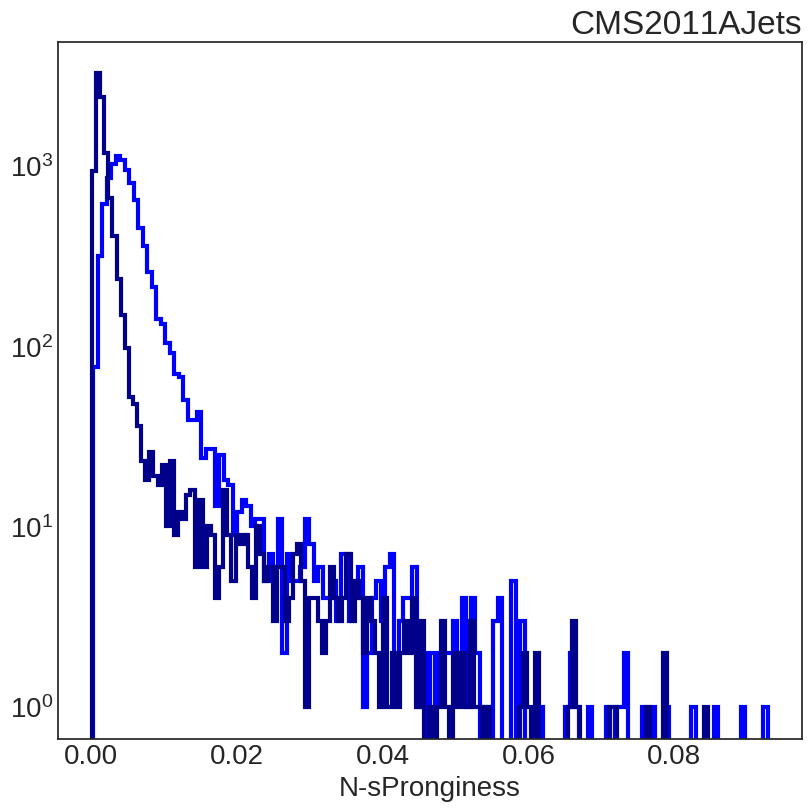

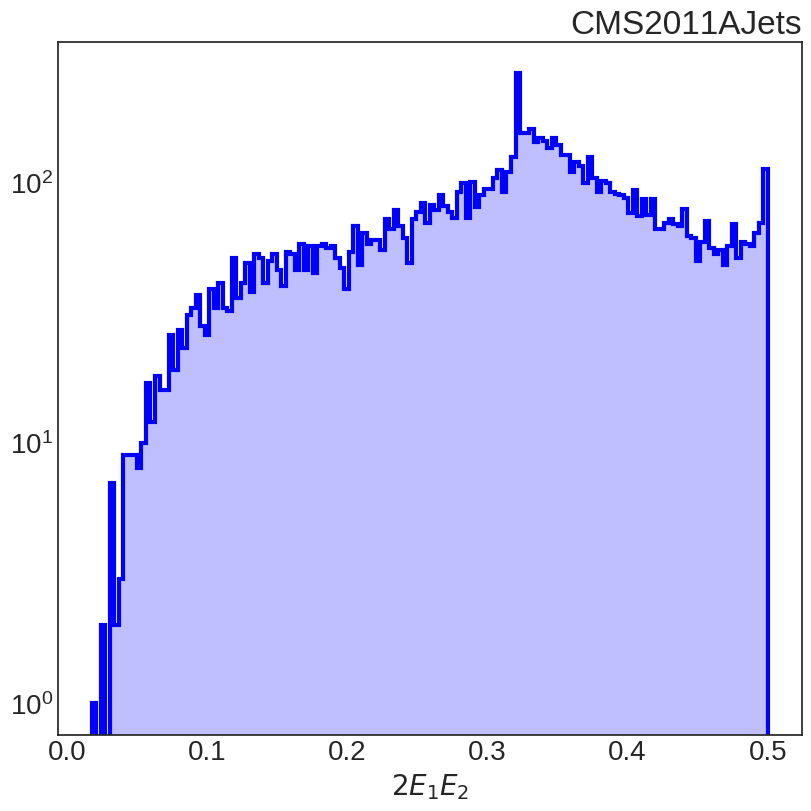

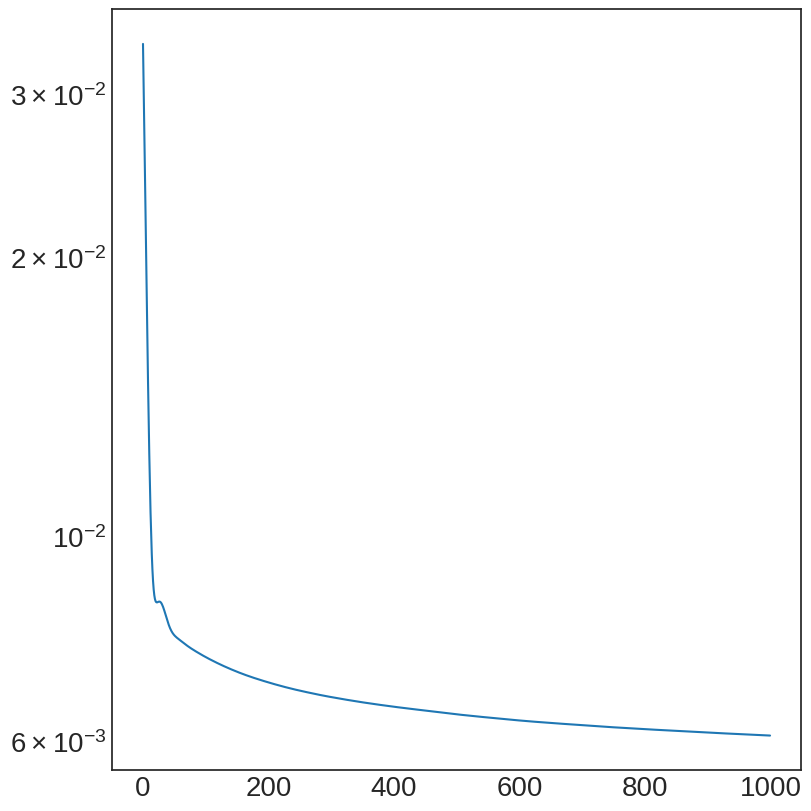

In [92]:
bins = 150
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

# plt.hist(sEMDs_real, color = "blue", alpha = 0.25, bins = bins)
plt.hist(sEMDs_real, color = "blue", histtype="step", lw = 3, bins = bins)
plt.yscale('log')
plt.title("CMS2011AJets", loc = "right")
plt.xlabel("N-sPronginess")


# plt.hist(sEMDs_real, color = "blue", alpha = 0.25, bins = bins)
plt.hist(sEMDs_real3, color = "darkblue", histtype="step", lw = 3, bins = bins)
plt.yscale('log')
plt.title("CMS2011AJets", loc = "right")
plt.xlabel("N-sPronginess")


# #######################

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

_2ee = 2 * events[:,0,0] * events[:,1,0]


plt.hist(_2ee, color = "blue", alpha = 0.25, bins = bins)
plt.hist(_2ee, color = "blue", histtype="step", lw = 3, bins = bins)
plt.yscale('log')
plt.title("CMS2011AJets", loc = "right")
plt.xlabel("$2E_1E_2$")



# #######################


plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  


plt.plot(np.mean(losses, axis = 1))
plt.yscale('log')
